In [90]:
import pandas as pd
import numpy as np
import ast
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# train_full_class_df = pd.read_csv("/content/drive/MyDrive/train_new.csv")
train_df = pd.read_csv("/content/drive/MyDrive/test_new.csv")
val_df = pd.read_csv("/content/drive/MyDrive/val_pipeline.csv")

In [91]:
train_text = []
val_text = []

for index, row in train_df.iterrows():
  stri = f"""
  username: {row['username']},
  company: {row['inferred company']},
  image url status: {row['image_url_status']},
  video url status: {row['video_thumbnail_status']},
  gif url status: {row['gif_thumbnail_status']}
  """
  train_text.append(stri)

for index, row in val_df.iterrows():
  stri = f"""
  username: {row['username']},
  company: {row['inferred company']},
  image url status: {row['image_url_status']},
  video url status: {row['video_thumbnail_status']},
  gif url status: {row['gif_thumbnail_status']}
  """
  val_text.append(stri)

In [92]:
train_df = train_df.drop(columns=['image_url', 'video_thumbnail_url', 'video_url',
                    'gif_thumbnail_url', 'gif_url', 'is_url_active', 'date', 'media', 'Unnamed: 0', 'text_status', 'image_url_status', 'video_url_status', 'video_thumbnail_status','gif_thumbnail_status', 'gif_url_status', 'inferred company'])

train_df['video_bitrate'] = train_df['video_bitrate'].replace("Does not exist", 0)
train_df['video_bitrate'] = train_df['video_bitrate'].replace("0", 0)
train_df['video_duration'] = train_df['video_duration'].replace("Does not exist", 0)
train_df['video_duration'] = train_df['video_duration'].replace("0", 0)
train_df['video_views'] = train_df['video_views'].replace("Does not exist", 0)
train_df['video_views'] = train_df['video_views'].replace("0", 0)

train_df['gif_bitrate'] = train_df['gif_bitrate'].replace("Does not exist", 0)
train_df['gif_bitrate'] = train_df['gif_bitrate'].replace("0", 0)

train_df['video_bitrate'] = train_df['video_bitrate'].astype(float)
train_df['video_duration'] = train_df['video_duration'].astype(float)
train_df['video_views'] = train_df['video_views'].astype(float)
train_df['gif_bitrate'] = train_df['gif_bitrate'].astype(float)

def convert_to_tuple(string):
    return ast.literal_eval(string)

train_df['image_size'] = train_df['image_size'].fillna('(0, 0)')
train_df['image_size'] = train_df['image_size'].apply(convert_to_tuple)

train_df[['image_heigth', 'image_width']] = pd.DataFrame(train_df['image_size'].tolist(), columns=['image_height', 'image_heigth'])

train_df.drop('image_size', axis=1, inplace=True)
train_df['languages'] = train_df['languages'].str.strip("[]")
train_df['languages'] = train_df['languages'].str.strip("'")

for language in train_df['languages'].unique():
  if language != 'ENGLISH' and language != 'Unknown':
    train_df['languages'] = train_df['languages'].replace(language, "Another Language")

train_df = train_df.drop(columns=['username', 'content'])

likes_list = train_df['likes']

train_df = pd.get_dummies(train_df)
len(train_df.columns)

41

In [93]:
val_df = val_df.drop(columns=['image_url', 'video_thumbnail_url', 'video_url',
                    'gif_thumbnail_url', 'gif_url', 'is_url_active', 'date', 'media', 'Unnamed: 0', 'text_status', 'image_url_status', 'video_url_status', 'video_thumbnail_status','gif_thumbnail_status', 'gif_url_status', 'username', 'inferred company'])

val_df['video_bitrate'] = val_df['video_bitrate'].replace("Does not exist", 0)
val_df['video_bitrate'] = val_df['video_bitrate'].replace("0", 0)
val_df['video_duration'] = val_df['video_duration'].replace("Does not exist", 0)
val_df['video_duration'] = val_df['video_duration'].replace("0", 0)
val_df['video_views'] = val_df['video_views'].replace("Does not exist", 0)
val_df['video_views'] = val_df['video_views'].replace("0", 0)

val_df['gif_bitrate'] = val_df['gif_bitrate'].replace("Does not exist", 0)
val_df['gif_bitrate'] = val_df['gif_bitrate'].replace("0", 0)

val_df['video_bitrate'] = val_df['video_bitrate'].astype(float)
val_df['video_duration'] = val_df['video_duration'].astype(float)
val_df['video_views'] = val_df['video_views'].astype(float)
val_df['gif_bitrate'] = val_df['gif_bitrate'].astype(float)

def convert_to_tuple(string):
    return ast.literal_eval(string)

val_df['image_size'] = val_df['image_size'].fillna('(0, 0)')
val_df['image_size'] = val_df['image_size'].apply(convert_to_tuple)

val_df[['image_heigth', 'image_width']] = pd.DataFrame(val_df['image_size'].tolist(), columns=['image_height', 'image_heigth'])

val_df.drop('image_size', axis=1, inplace=True)
val_df['languages'] = val_df['languages'].str.strip("[]")
val_df['languages'] = val_df['languages'].str.strip("'")

for language in val_df['languages'].unique():
  if language != 'ENGLISH' and language != 'Unknown':
    val_df['languages'] = val_df['languages'].replace(language, "Another Language")

val_df = val_df.drop(columns=['content'])
likes_list = val_df['likes']

val_df = pd.get_dummies(val_df)
len(val_df.columns)

41

In [94]:
loaded_model = xgb.Booster()
loaded_model.load_model('/content/drive/MyDrive/xg_boost_outlier_score_model.bin')

In [95]:
train_df_likes = train_df['likes'].values
train_df = train_df.drop(columns=['likes'])
val_df_likes = val_df['likes'].values
val_df = val_df.drop(columns=['likes'])

In [96]:
X = train_df
y = train_df_likes
dtrain = xgb.DMatrix(data=X, label=y)
predictions_train = loaded_model.predict(dtrain)

X = val_df
y = val_df_likes
dtest = xgb.DMatrix(data=X, label=y)
predictions_test = loaded_model.predict(dtest)

In [97]:
train_df['outlier_score'] = predictions_train
val_df['outlier_score'] = predictions_test

In [98]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, y_train = train_df, train_df_likes
X_test, y_test = val_df, val_df_likes

quantile_transformer = QuantileTransformer(output_distribution='normal')
y_transformed_train = quantile_transformer.fit_transform(y_train.reshape(-1, 1)).flatten()
y_transformed_test = quantile_transformer.transform(y_test.reshape(-1, 1)).flatten()

vectorizer = TfidfVectorizer()
X_train_text = vectorizer.fit_transform(train_text)
X_test_text = vectorizer.transform(val_text)

params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'objective': 'reg:squarederror'
}

dtrain = xgb.DMatrix(X_train, label=y_transformed_train)
dtest = xgb.DMatrix(X_test, label=y_transformed_test)

num_round = 100
model = xgb.train(params, dtrain, num_round)

train_predictions = model.predict(dtrain)
text_regressor = LinearRegression()
text_regressor.fit(X_train_text, y_transformed_train)
train_text_predictions = text_regressor.predict(X_train_text)
train_combined_features = np.column_stack((train_text_predictions, train_predictions))
meta_model = LinearRegression()
meta_model.fit(train_combined_features, y_transformed_train)

test_predictions = model.predict(dtest)
test_text_predictions = text_regressor.predict(X_test_text)
test_combined_features = np.column_stack((test_text_predictions, test_predictions))
predictions = meta_model.predict(test_combined_features)

y_pred_inverse = quantile_transformer.inverse_transform(predictions.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_pred_inverse, y_test)
print(f"Root Mean Squared Error (MSE): {np.sqrt(mse)}")

Root Mean Squared Error (MSE): 4103.009313415427


In [99]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_inverse)

0.1447938670994734

In [100]:
var1 = y_test
var2 = y_pred_inverse
sorted_indices = np.argsort(var1)
sorted_var1 = var1[sorted_indices]
sorted_var2 = var2[sorted_indices]

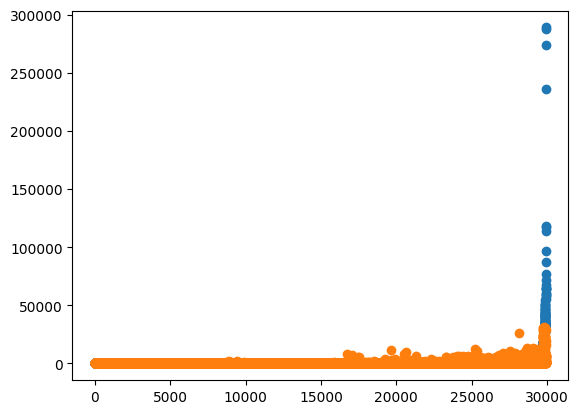

In [101]:
import matplotlib.pyplot as plt
indices = range(len(var1))
plt.scatter(indices, sorted_var1, label='Predicted')
plt.scatter(indices, sorted_var2, label='Actual')